### In this project we will clean the text using stopwords. We aim to build a GloVe - RNN model for detecting the sarcasm.

In [1]:
import numpy as np 
import pandas as pd 
import os
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
from keras.layers import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


## Load the text dataset

In [2]:
data = pd.read_csv("sarcasm_detection.csv")
data.head()

,ID,comment,date,down,parent_comment,score,top,topic,user,label
0,uid_590555,"Well, let's be honest here, they don't actuall...",2015-04,0,They should shut the fuck up and let the commu...,2,2,starcitizen,Combat_Wombatz,0
1,uid_671762,"Well, I didn't need evidence to believe in com...",2016-12,-1,You need evidence to kill people? I thought we...,6,-1,EnoughCommieSpam,starkadd,1
2,uid_519689,"Who does an ""official promo"" in 360p?",2013-11,0,2014 BMW S1000R: Official Promo,3,3,motorcycles,phybere,0
3,uid_788362,Grotto koth was the best,2015-09,0,Not really that memorable lol if you want memo...,2,2,hcfactions,m0xyMC,1
4,uid_299252,Neal's back baby,2015-11,0,James Neal hit on Zach Parise,-5,-5,hockey,Somuch101,1


## Cleaning data

#### Replace contractions, stopwords, punctuations, urls, emoticons , symbols & pictographs, transport & map symbols

In [3]:
def clean_text(text):
    text = text.lower()
    
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = emoji.sub(r'', text)
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

In [8]:
! pip install nltk
import nltk
nltk.download('punkt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [10]:
 nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Tokenise the cleaned corpus

In [11]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def CleanTokenize(df):
    cleaned_ = list()
    lines = df["comment"].values.tolist()

    for line in lines:
        line = clean_text(line)
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        # remove stop words
        words = [w for w in words if not w in stop_words]
        cleaned_.append(words)
    return cleaned_

cleaned_comments = CleanTokenize(data)
cleaned_comments[0:10]


[['well',
  'lets',
  'honest',
  'actually',
  'seem',
  'much',
  'moderating',
  'spend',
  'time',
  'something'],
 ['well', 'didnt', 'need', 'evidence', 'believe', 'communism'],
 ['official', 'promo'],
 ['grotto', 'koth', 'best'],
 ['neals', 'back', 'baby'],
 ['orange',
  'new',
  'black',
  'house',
  'cards',
  'hemlock',
  'grove',
  'going',
  'see',
  'worth',
  'watching',
  'hype'],
 ['pff', 'everybody', 'knows', 'science', 'sexist'],
 ['called', 'rmmas', 'golden', 'boy', 'sage', 'shitlist', 'since'],
 ['dudes', 'though'],
 ['probably', 'followed', 'original', 'comment']]

## Create a word cloud for vizualizing the most common words in the corpus

(-0.5, 999.5, 499.5, -0.5)

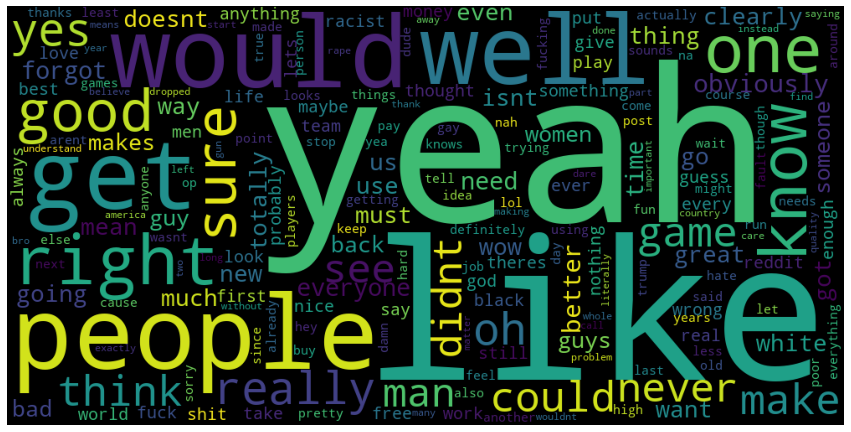

In [12]:
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
pos_data = data.loc[data['label'] == 1]
pos_head_lines = CleanTokenize(pos_data)
pos_lines = [j for sub in pos_head_lines for j in sub] 
word_could_dict=Counter(pos_lines)

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")


## Test - train split:

In [13]:
validation_split = 0.2
max_length = 25


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(cleaned_comments)
sequences = tokenizer_obj.texts_to_sequences(cleaned_comments)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  data['label'].values

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

unique tokens -  17225
vocab size - 17226


In [14]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (12000, 25)
Shape of y_train: (12000,)
Shape of X_test_pad: (3000, 25)
Shape of y_test: (3000,)


## Prepare GloVe model to create embeddings

In [15]:
embeddings_index = {}
embedding_dim = 100
GLOVE_DIR = "."
f = open(os.path.join(GLOVE_DIR, 'glove.twitter.27B.100d.txt'), encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Found 28231 word vectors.


In [16]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
c = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector
print(c)


7230


### Build embedding layer

In [17]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)


## Build RNN

In [18]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print('Summary of the built model...')
print(model.summary())

Summary of the built model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 100)           1722600   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1,764,905
Trainable params: 42,305
Non-trainable params: 1,722,600
_________________________________________________________________
None


## Train the model:

In [19]:
history = model.fit(X_train_pad, y_train, batch_size=32, epochs=25, validation_data=(X_test_pad, y_test), verbose=1)

Epoch 1/25
375/375 [==============================] - 14s 33ms/step - loss: 0.6808 - acc: 0.5560 - val_loss: 0.6628 - val_acc: 0.6097
Epoch 2/25
375/375 [==============================] - 13s 35ms/step - loss: 0.6603 - acc: 0.6000 - val_loss: 0.6554 - val_acc: 0.6110
Epoch 3/25
375/375 [==============================] - 12s 32ms/step - loss: 0.6483 - acc: 0.6275 - val_loss: 0.6552 - val_acc: 0.6123
Epoch 4/25
375/375 [==============================] - 12s 32ms/step - loss: 0.6382 - acc: 0.6302 - val_loss: 0.6473 - val_acc: 0.6210
Epoch 5/25
375/375 [==============================] - 12s 32ms/step - loss: 0.6312 - acc: 0.6432 - val_loss: 0.6693 - val_acc: 0.6180
Epoch 6/25
375/375 [==============================] - 12s 32ms/step - loss: 0.6223 - acc: 0.6476 - val_loss: 0.6469 - val_acc: 0.6280
Epoch 7/25
375/375 [==============================] - 13s 35ms/step - loss: 0.6135 - acc: 0.6572 - val_loss: 0.6475 - val_acc: 0.6383
Epoch 8/25
375/375 [==============================] - 12s 32ms

## Visualize the learning outcome metrics

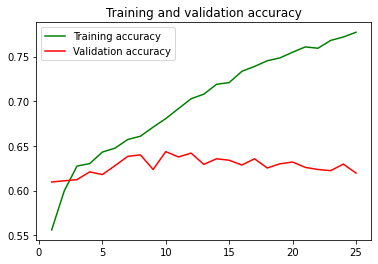

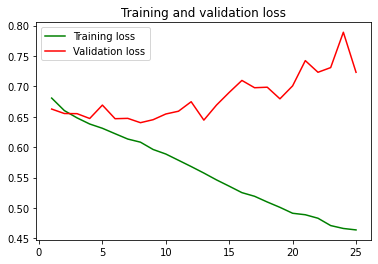

In [20]:
# Plot results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Detect sarcasm:


In [24]:
def predict_sarcasm(s):
    x_final = pd.DataFrame({"comment":[s]})
    test_lines = CleanTokenize(x_final)
    test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
    test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
    pred = model.predict(test_review_pad)
    pred*=100
    if pred[0][0]>=50: return "It's a sarcasm!" 
    else: return "It's not a sarcasm."

In [25]:
predict_sarcasm("I was depressed. He asked me to be happy. I am not depressed anymore.")

"It's not a sarcasm."

In [27]:
predict_sarcasm("His name is Bob. He is a nice person.")

"It's a sarcasm!"

In [28]:
predict_sarcasm("because he called out r/mma's golden boy sage and has been on their shitlist since")


"It's a sarcasm!"

## Conclusion:

We cleaned and preprocessed the text data by replacing contractions, stopwords, punctuations, urls, emoticons , symbols & pictographs, transport & map symbols.

Created a word cloud to visualize the most commonly used vocabulary used in the corpus.

We built a GloVe - RNN model for detecting the sarcasm.
Achieved a cross validation accuracy of over 0.60
